# Evolution and Statistics of Large-scale Structure and Statistics of Large-scale Structure

## Part I - N-body Simulations of Cosmic Structure Formation

In this part of the tutorial, we will run an N-body simulations to simulate cosmic structure formation---from the tiny primordial density fluctuations we observe in the Cosmic Microwave Background (CMB) anisotropies using the Planck satellite [1] and Atacama Cosmology Telescope [2], to the cosmic large-scale structure we observe by mapping the spatial distribution of galaxies in large galaxy surveys like Dark Energy Spectroscopic Instrument [3], Euclid [4] and Prime Focus Spectrograph [5].

[1] [Planck Collaboration (2020)](https://arxiv.org/abs/1807.06209)

[2] [ACT Collaboration (2025)](https://arxiv.org/abs/2503.14452)

[3] [DESI Collaboration (2025)](https://arxiv.org/abs/2503.14738)

[4] [Euclid Collaboration (2025)](https://arxiv.org/abs/2503.15302)

[5] [PFS Collaboration (2013)](https://arxiv.org/abs/1206.0737)

We first install `CAMB` [6] because later we want to generate the linear matter power spectrum $P_L(k)$ (exactly what you have done in Elisa's hands-on session).

[6] [A. Lewis, A. Challinor, A. Lasenby (2000)](https://arxiv.org/abs/astro-ph/9911177)

In [ ]:
!pip install camb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00


### $P_L(k)$ in PL18-cosmology from `CAMB`

Recall Elisa's session. We will load the PL18 best-fit cosmology and use that as input for `CAMB`.

In [ ]:
import camb
from camb import model, initialpower

In [ ]:
# Load `camb` .ini file with the best-fit PL18 cosmology
pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
#print(pars)

# Set the cosmological redshift z=1/a-1 and the maximum Fourier wavenumber k we want to output the linear matter power spectrum pk_lin at using `pars.set_matter_power`
pars.set_matter_power(redshifts=[0.,], kmax=10.)

# Compute the linear matter power spectrum pk_lin using `camb.get_results.get_matter_power_spectrum`
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
k_lin, z, pk_lin = results.get_matter_power_spectrum(minkh=5e-4, maxkh=10., npoints=1000)

Some quick visual inspection. Recall the main features of the linear matter power spectrum $P_L(k)$ we have discussed during Elisa's lecture and mine.

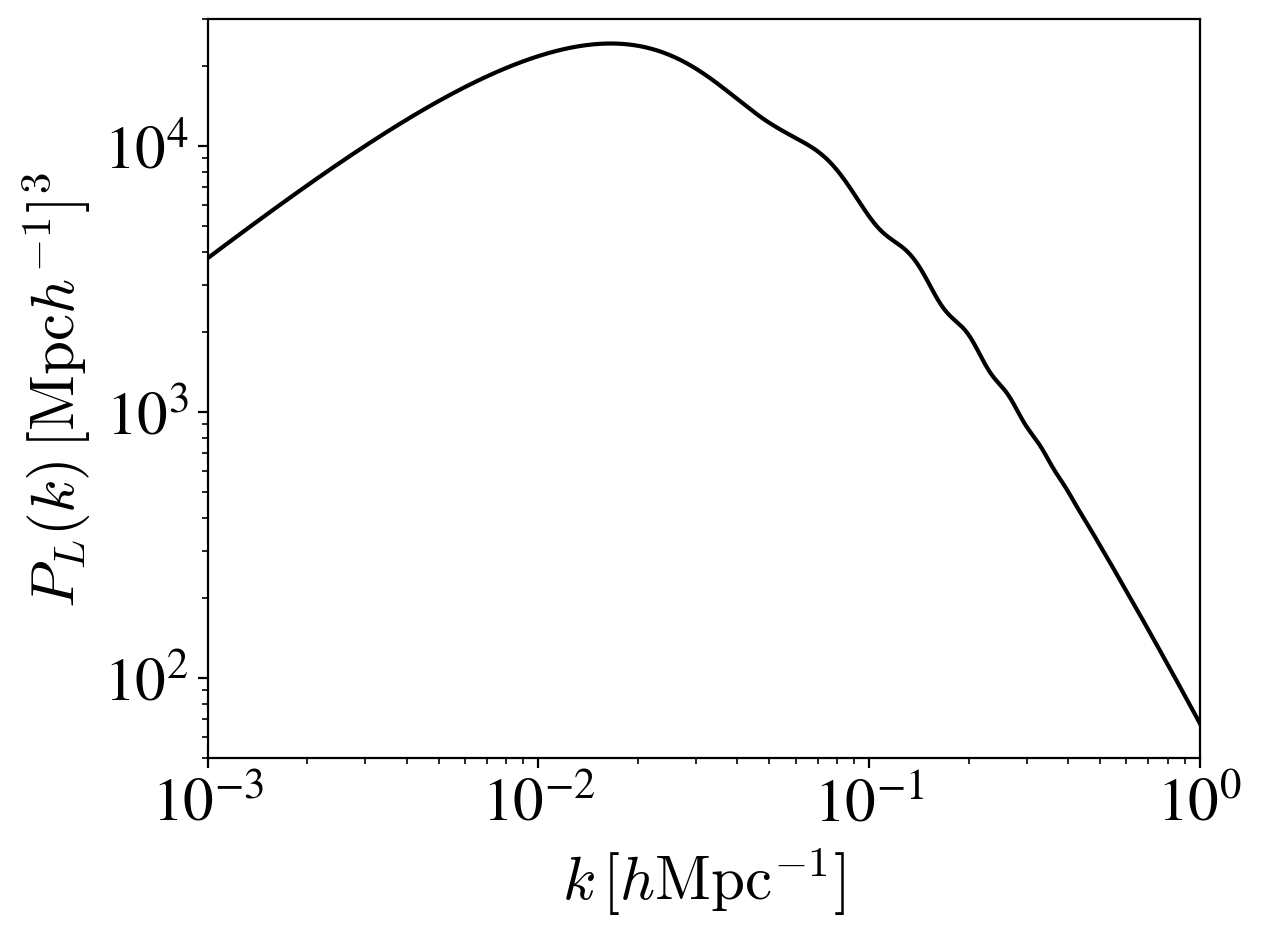

In [ ]:
from matplotlib import pyplot as plt
#### Matplotlib Backend and Style - Personal preference
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})
####

fig,ax=plt.subplots()
ax.loglog(k_lin, pk_lin[0,:], color='k', ls ='-')
ax.set_xlabel('$k\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel('$P_L(k)\,[\mathrm{Mpc}h^{-1}]^3$')
ax.set_xlim(1e-3,1);
ax.set_ylim(50,3e4);

### Run an N-body cosmological simulation to simulate cosmic structure formation in the PL18-bestfit cosmology

We now install the main package, `FlowPM` [7]. It is a particle-mesh code to simulate the evolution of an N-body system under gravitational interactions.

[8] [C. Modi, F. Lanusse, U. Seljak (2020)](https://arxiv.org/abs/2010.11847)

In [ ]:
!pip install tensorflow tensorflow_probability tf-keras flowpm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.2/385.2 kB 17.5 MB/s eta 0:00:00
  Created wheel for flowpm: filename=flowpm-0.1.1-py3-none-any.whl size=33867 sha256=01458c07df57da3297e29a0c2f3278e42494c94c9ebb58aa456a0a9b0f1cc4ea
  Stored in directory: /root/.cache/pip/wheels/a4/51/ea/b6fe26c004b3f80bff1d5f173cc7bb82035ee04fab91e43201
Successfully built flowpm


#### Setup

We need to specify specifications for the simulation. These include:

- Starting cosmological scale factor, i.e. the initial starting cosmic time of the simulation (recall that in cosmology we measure time by cosmological redshift or scale factor) `a_init`.
- Final cosmological scale factor, i.e. the final cosmic time to stop and output the simulation `a_final`.
- Number of simulation time steps `n_steps`.
- Side length of the simulation cube `L_side` (note that `Volume=L_side**3`).
- Number of of mesh points along one side of the cube `N_side` (note that `N_particle=(N_side)**3`).

In [ ]:
import numpy as np
import tensorflow as tf
import flowpm

In [ ]:
# Define key parameters of our Universe
a_init     = 0.02 # quiz: Which redshift is this? Was the universe dominated by radiation, (dark) matter or dark energy at this point?
a_final      = 1.0
n_steps = 10 # 10-30 steps is really sufficient for our purposes
L_side       = 100. # in comoving unit [Mpc/h]; larger box size at the same number of mesh points means lower resolution
N_side       = 64 # more mesh points means slower sims
batch   = 1 # number of simulations

stages = np.linspace(a_init, a_final, n_steps, endpoint=True) #time-steps for the integration

We need one final ingredient: the linear matter power spectrum $P_L(k)$. `FlowPM` takes as input an interpolator of $P_L(k)$. So we will make one out of the `pk_lin` we computed from `camb` earlier, using `scipy.interpolate.InterpolatedUnivariateSpline`

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
ipk_lin = iuspline(k_lin, pk_lin)

#### Execute

Ready to go! Let the universe evolve!

In [ ]:
RNG_seed=1234
tf.compat.v1.reset_default_graph()
# Generate initial conditions of the simulation
initial_conditions = flowpm.linear_field(N_side,  L_side, ipk_lin, batch_size=batch,seed=RNG_seed); # quiz: What kind of distribution do initial conditions follow?

# Generate the initial displacement and velocity for simulation particles
init_state = flowpm.lpt_init(initial_conditions, a_init);
# State is a tensor of shape (3, batch, N^3, 3)
# the last axis corresponds to the x, y, z coordinates
# the first axis corresponds to position, velocity, acceleration of the particle

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(init_state, stages, N_side);

#### Visual inspection of intial conditions and final matter distribution

Visualize the initial conditions $(z=49)$ and final matter distribution $(z=0)$ byt scattering the particles at `initial_state` and `final_state`, respectively.

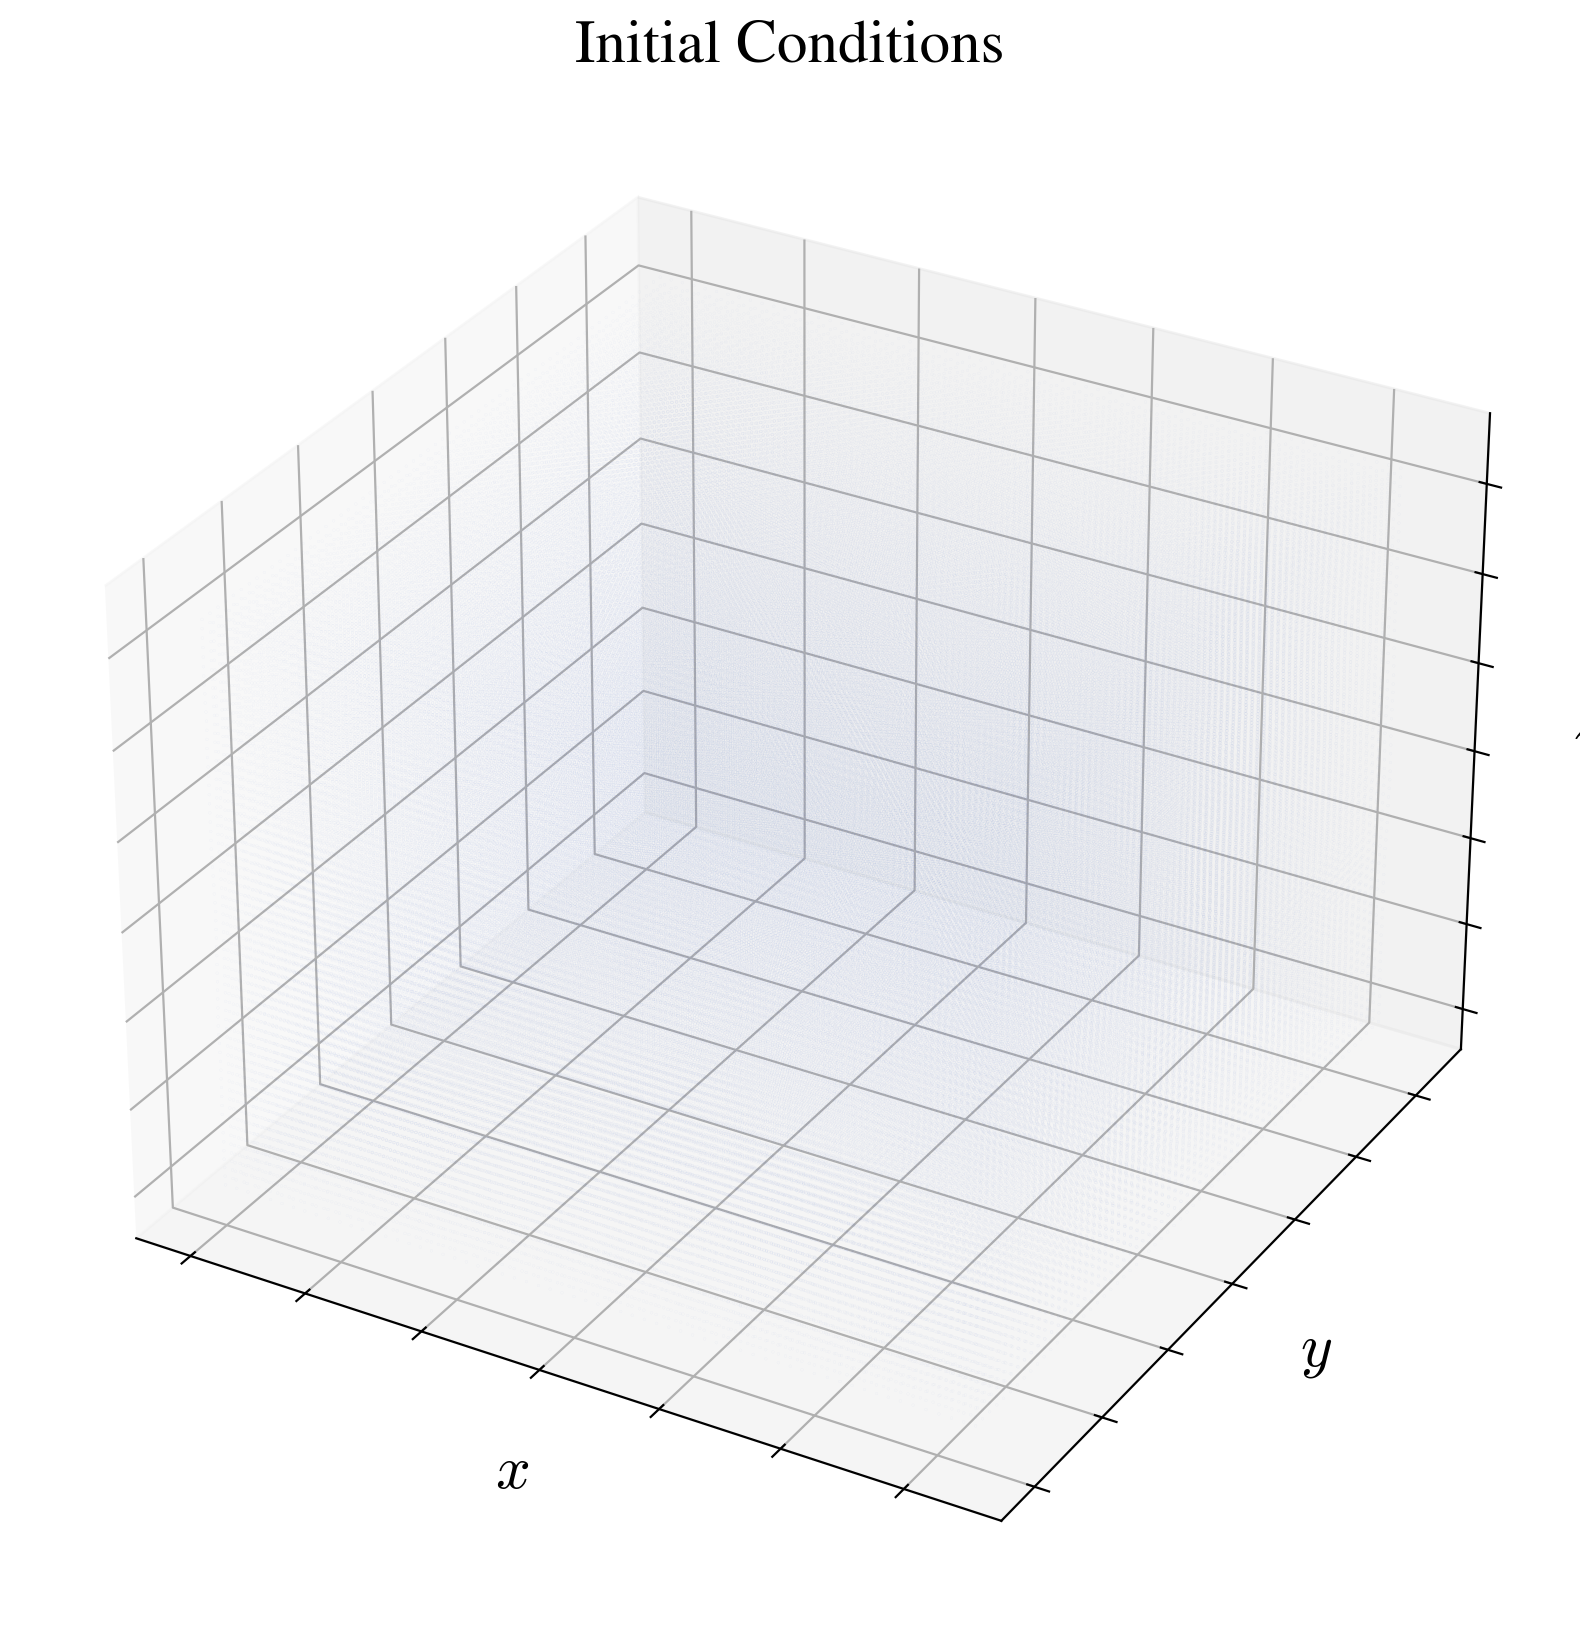

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(10,10))
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig)
ax.scatter(init_state[0, 0,:,0],init_state[0, 0,:,1], init_state[0, 0,:,2],color="royalblue",marker=".",s=.015,alpha=0.1);
ax.set_xlabel(r"$x$",fontsize=22)
ax.set_ylabel(r"$y$",fontsize=22)
ax.set_zlabel(r"$z$",fontsize=22)
ax.set_title("Initial Conditions",fontsize=22)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
ax.zaxis.set_ticklabels([]);

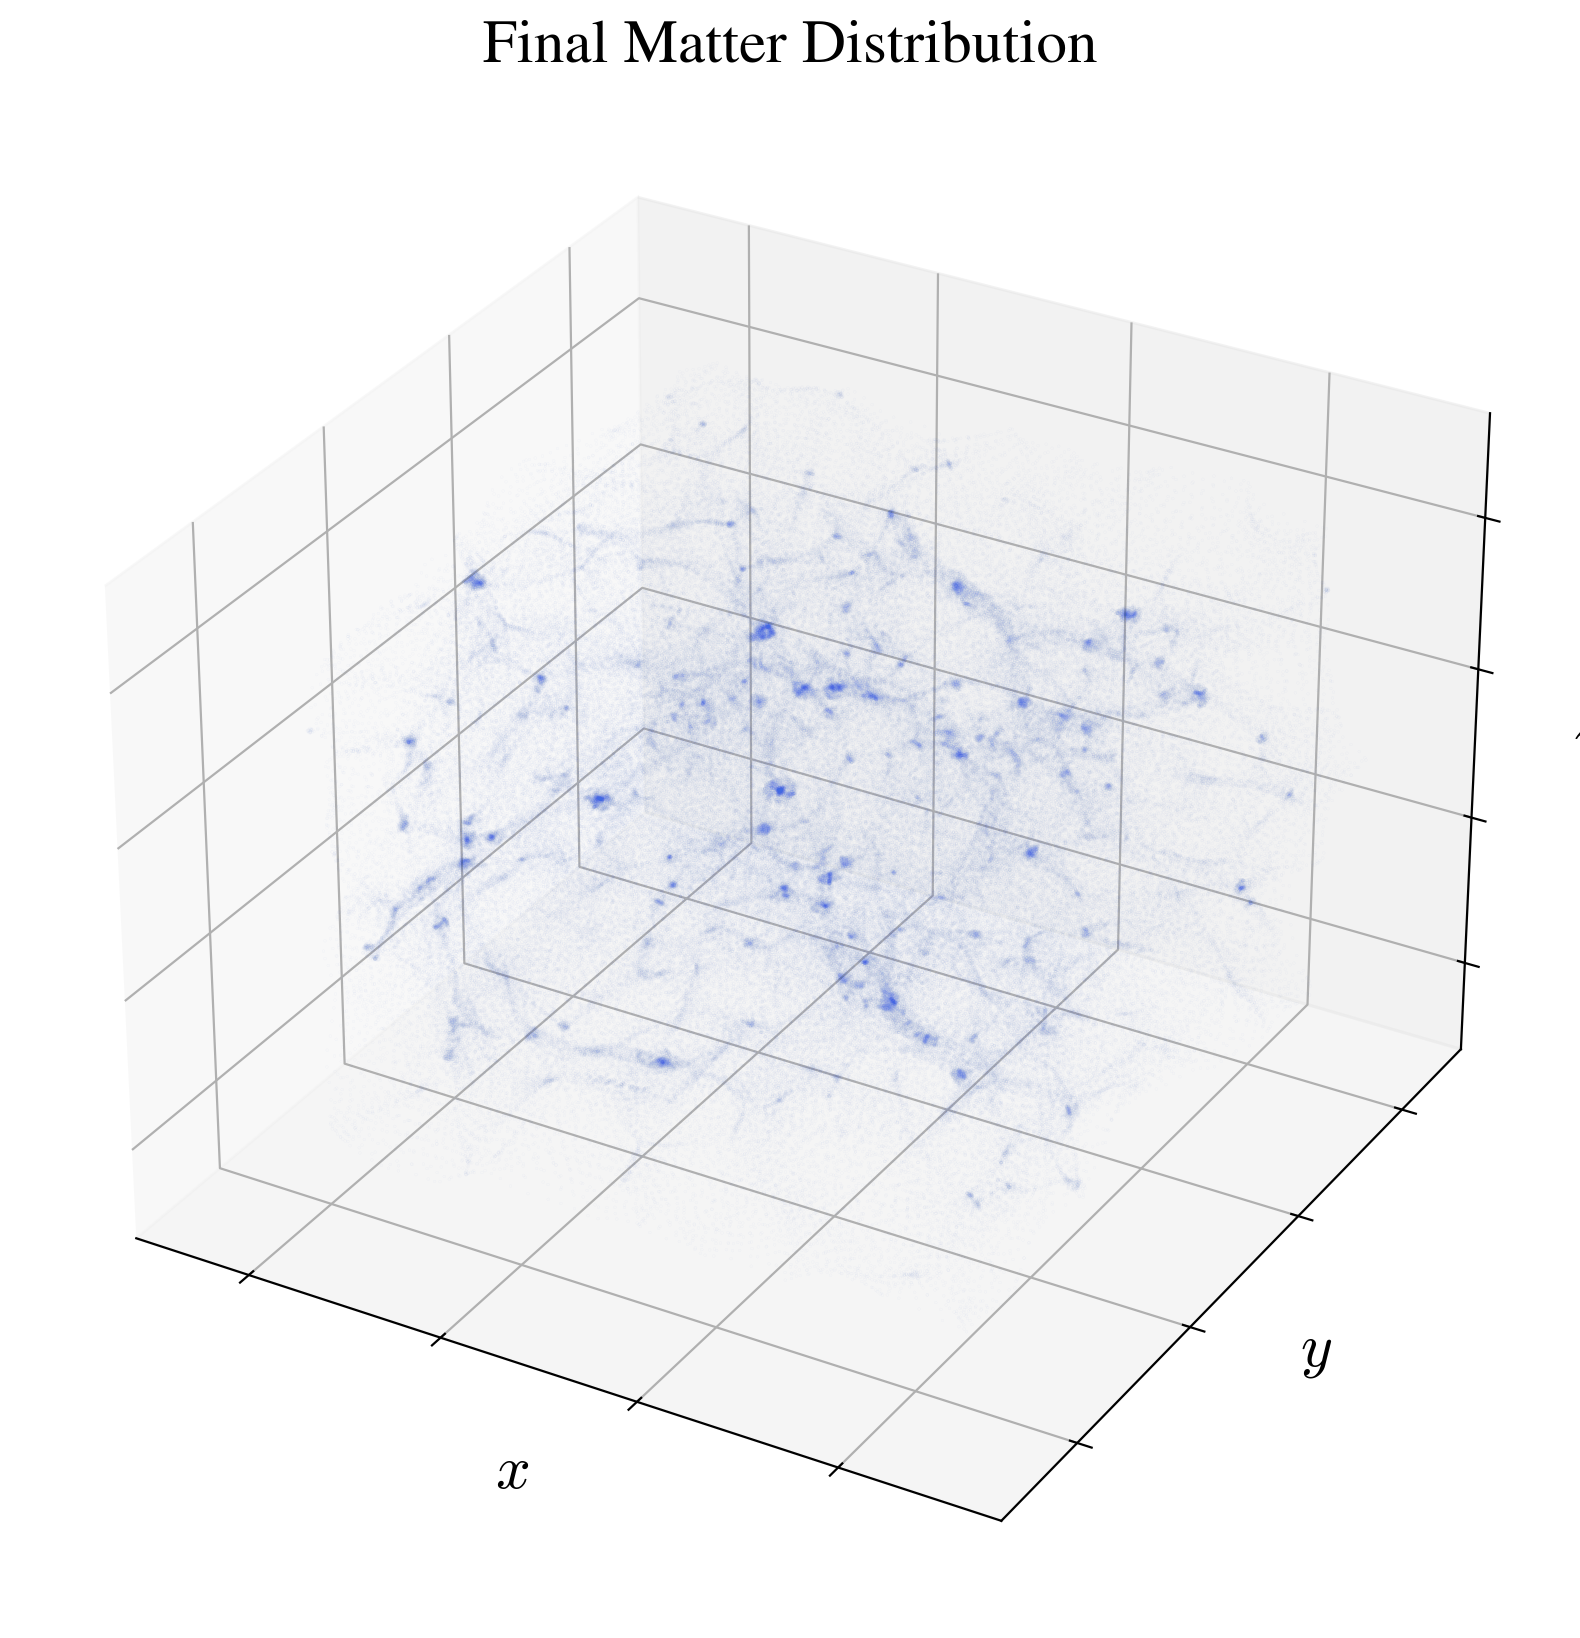

In [ ]:
fig=plt.figure(figsize=(10,10))
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig)
ax.scatter(final_state[0, 0,:,0],final_state[0, 0,:,1], final_state[0, 0,:,2],color="royalblue",marker=".",s=.015,alpha=0.1);
ax.set_xlabel(r"$x$",fontsize=22)
ax.set_ylabel(r"$y$",fontsize=22)
ax.set_zlabel(r"$z$",fontsize=22)
ax.set_title("Final Matter Distribution",fontsize=22)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
ax.zaxis.set_ticklabels([]);

To construct the matter density fields at $z=99$ and $z=0$ we need to interpolate the particles to a grid. The common interpolation kernels are `NGP`, `CIC` and `TSC`. Below we use `CIC`.

In [ ]:
# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
final_density_field = (final_field[batch_id]/final_field[batch_id].numpy().mean())-1

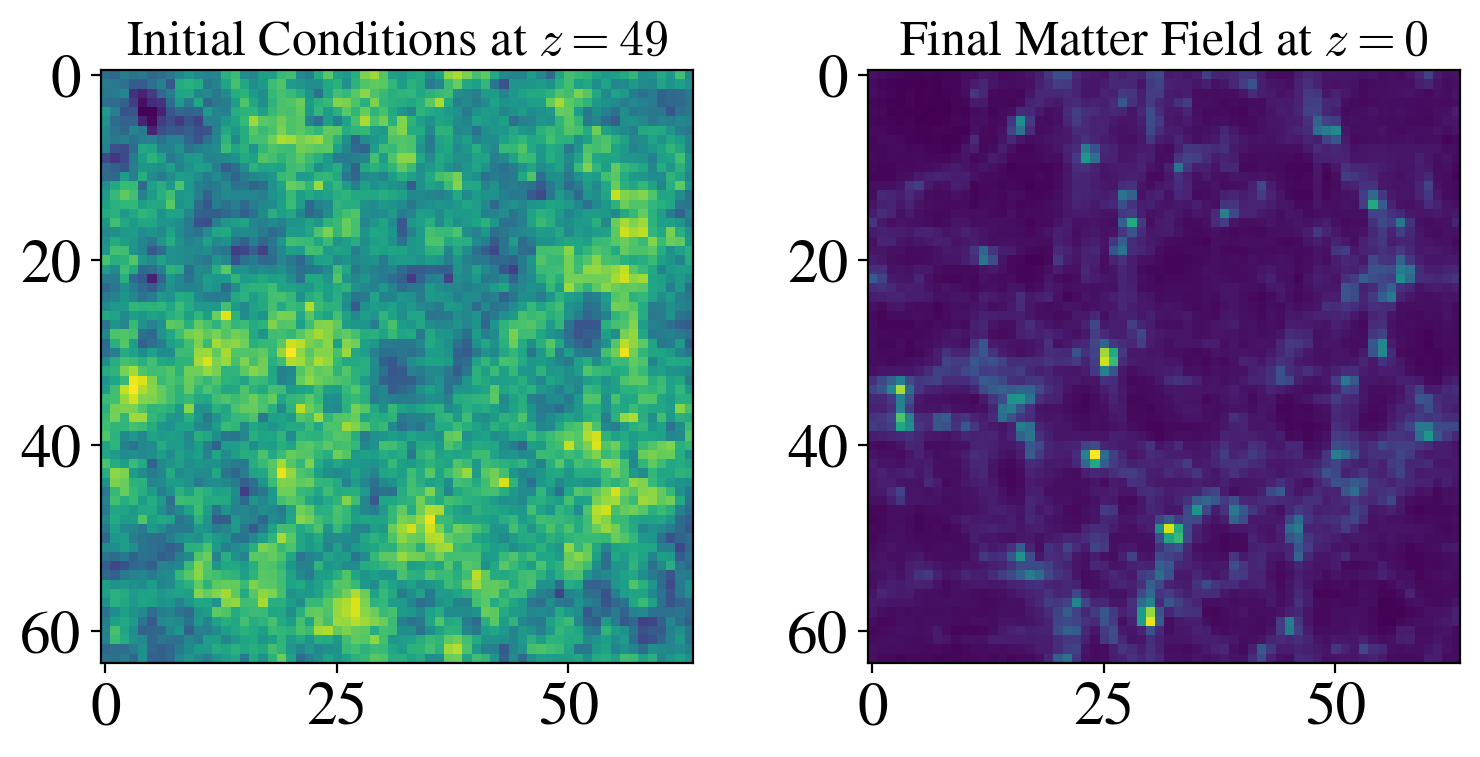

In [ ]:
batch_id = 0  #batch index of the simulation in the batch

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(initial_conditions[batch_id].numpy().sum(axis=0))
ax[0].set_title(r'Initial Conditions at $z=49$',fontsize=18)
ax[1].imshow(final_density_field.numpy().sum(axis=0))
ax[1].set_title(r'Final Matter Field at $z=0$',fontsize=18)
plt.tight_layout()

**BONUS**

 What is a simple way to verify whether the initial conditions are Gaussian while the final matter density field is not?

(-1.0, 3.0)

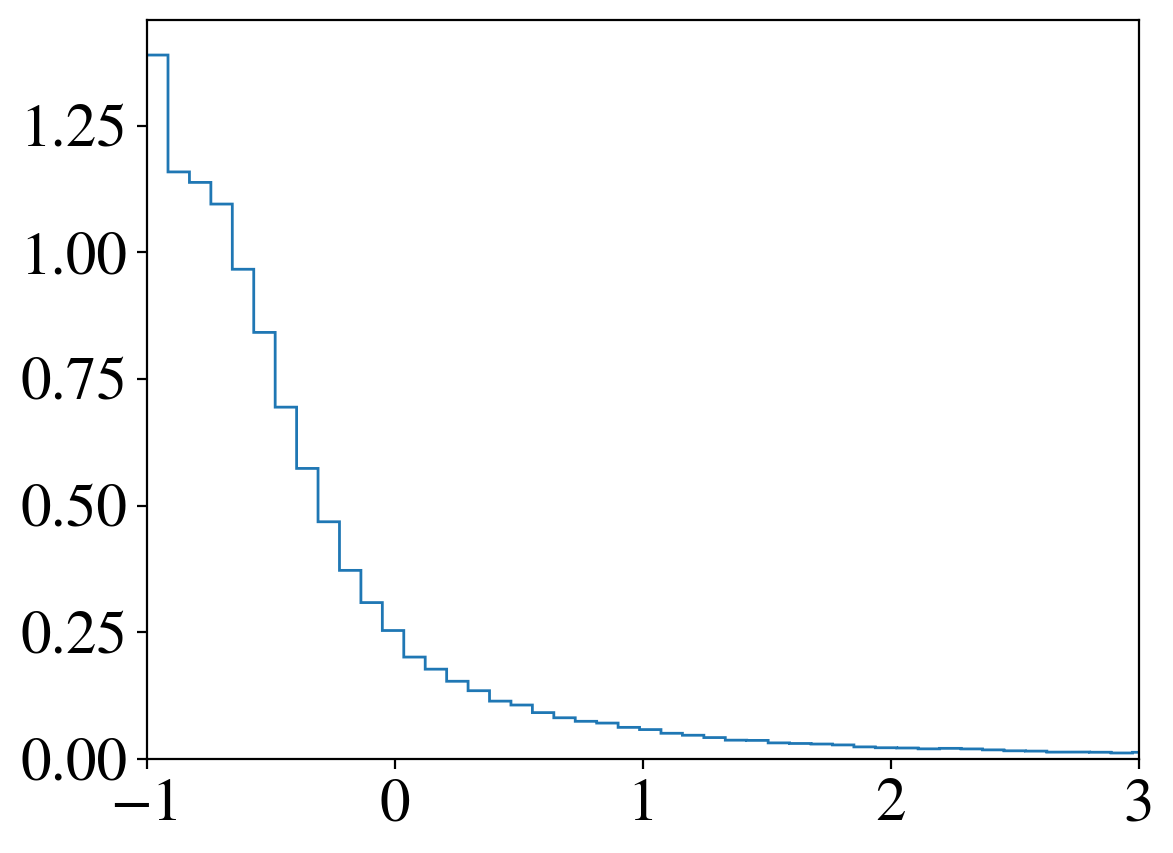

In [ ]:
fig, ax = plt.subplots()
ax.hist(final_density_field.numpy().flatten(),bins=3000,density=True,histtype='step')
ax.set_xlim(-1,3)

In [ ]:
initial_conditions[batch_id].numpy().max()

np.float32(15.442911)

## Part II - The (binned) power spectrum of the simulation

In the second part of the tutorial, we will estimate the power spectrum of the simulation `final_field` and compare that to the input `pk_lin`.

The power spectrum $P_{\delta\delta}(k)$ of the 3D density field $\delta$ in a cubic simulation box (with periodic boundary condition) is given by

$$P_{\delta\delta}\left(k_{\mathrm{center,i}}\right) = \mathrm{Norm}\times \frac{1}{N_{\mathrm{modes},i}}\sum_{k\geq k_{\mathrm{edge},i}}^{k<k_{\mathrm{edge},i}}\delta(k)\delta^\ast(k)$$.

Here, $k=|\mathbf{k}|$ is the Fourier wavenumber; $k_{\mathrm{center},i}$ is the center of the Fourier $k$-bin $i$, while $k_{\mathrm{edge},i}$ is the left edge of bin $i$.
$N_{\mathrm{modes},i}$ is the number of Fourier modes within bin $i$. So you can see that we're essentially taking the average of $P_{\delta\delta}(k)$ within bin $i$.

Norm is the FFT normalization factor (squared), which is $\frac{L_{\mathrm{side}}^3}{N_{\mathrm{side}}^6}$ where $L_{\mathrm{side}},N_{\mathrm{side}}$ are the length and number of grid cells/points along a side of the simulation box, respectively.

**Note**: In cosmology, $\delta(x)$ is a real field, $\delta^\ast(k)=\delta(-k)$.

We can either (1) install a package like `pypower` or `PolyBin3D` to compute the matter per spectrum, or (2) write our own function to estimate the power spectrum.

(1) or (2)? Your call!

### Option (1)

We can use either [`cosmodesi/pypower`](https://github.com/cosmodesi/pypower), developed by DESI, or [`PolyBin3D`](https://github.com/oliverphilcox/PolyBin3D) by Philcox and Floss. The latter has better documentation so we will use it for this exercise.

In [ ]:
!pip install pyfftw icecream git+https://github.com/oliverphilcox/PolyBin3D

  Cloning https://github.com/oliverphilcox/PolyBin3D to /tmp/pip-req-build-etkg6cz9
  Running command git clone --filter=blob:none --quiet https://github.com/oliverphilcox/PolyBin3D /tmp/pip-req-build-etkg6cz9
  Resolved https://github.com/oliverphilcox/PolyBin3D to commit 506c60e60a39da2255cb41a22f9d5c015f0e175e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.0 MB/s eta 0:00:00
  Created wheel for PolyBin3D: filename=PolyBin3D-0.0.0-py3-none-any.whl size=21692 sha256=126539ee5c2cfc340466c65da97a52fba2dc9f7e340d72fbadaf86504d63582d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ulfm65a/wheels/65/d7/0f/dec224ea25429a9fce0bdc1a42a8f4b8a5479afe2a1d28cffe
Successfully built PolyBin3D


#### Setup the $P(k)$ estimator

In [ ]:
import PolyBin3D as pb
# Load the PolyBin3D class
# Load base class
base = pb.PolyBin3D(L_side, # dimensions of box
                    N_side, # dimensions of Fourier-space grid,
                    boxcenter=[0,0,0], # center of simulation box
                    pixel_window='cic', # pixel window function
                    backend='fftw', # backend for performing FFTs ('fftw' for cpu, 'jax' for gpu)
                    nthreads=16, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                    sightline='global') # redshift-space axis

# Define the Fourier wavenumber k bins
k_min = (2.*np.pi)/L_side # quiz: Why are we setting k_min like this?
k_max = (np.pi)/(L_side/N_side) # quiz: Why are we setting k_max like this?
k_bins = np.arange(k_min,k_max,0.01)
# Define the maximum multipole number up to which we want to compute Pk
lmax = 0

# Load power spectrum class
pspec = pb.PSpec(base,
                 k_bins, # k-bin edges
                 lmax=lmax, # Legendre multipoles
                 mask=None, # real-space mask
                 applySinv=None, # filter to apply to data
                )


# Dimensions: [4.00e+02, 4.00e+02, 4.00e+02] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.016, 0.016, 0.016] h/Mpc
# Nyquist frequency: [1.005, 1.005, 1.005] h/Mpc
# Pixel window: cic
# Using fftw backend

Binning: 98 bins in [0.016, 0.996] h/Mpc
l-max: 0
Mask: constant


#### Compute $P(k)$ from `final_field`

In [ ]:
# Compute the ideal power spectrum
pk_pb = pspec.Pk_ideal(final_field)

# Define the k-bin centers
k_pb = pspec.get_ks()

#### Visual inspection of $P(k)$

Now we can compare $P_L(k,z=0)$ or `pk_lin` we get from `camb` earlier that we had used as input for the simulation earlier, and $P_{NL}(k,z=0)$ or `pk` that we have just estimated from the simulation box.

What is the difference (if any) that you could spot? Why should there be a difference (if any) between the two[link text](https://)?

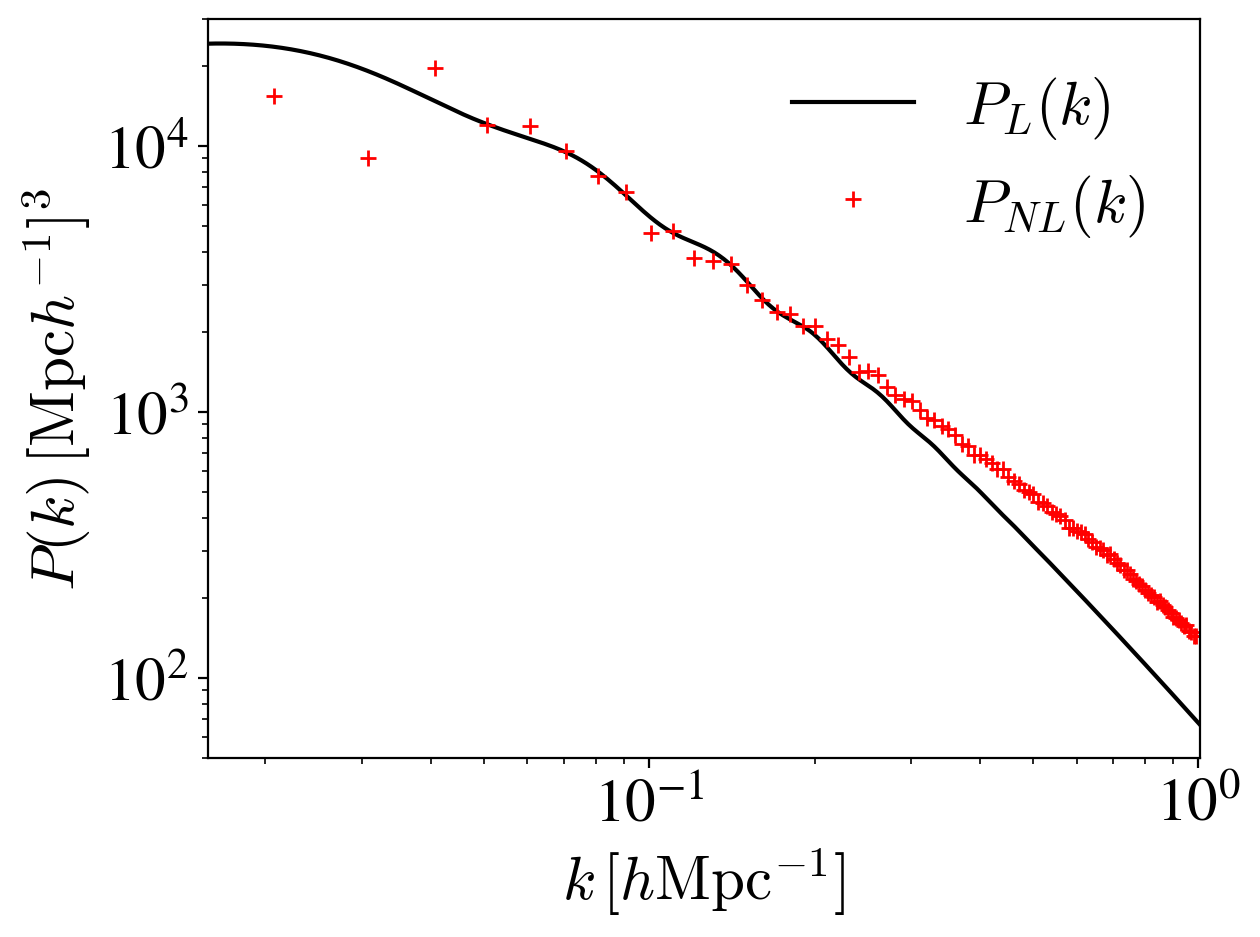

In [ ]:
ig,ax=plt.subplots()
ax.loglog(k_lin, pk_lin[0,:], color='k', ls ='-',label='$P_L(k)$')
ax.loglog(k_pb, pk_pb['p0'], color='r', ls='', marker ='+',label='$P_{NL}(k)$')
ax.set_xlabel('$k\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel('$P(k)\,[\mathrm{Mpc}h^{-1}]^3$')
ax.set_xlim(k_min,k_max);
ax.set_ylim(50,3e4);
ax.legend(frameon=False);

### Option (2), or BONUS if you already tried Option (1) above

It's really great that you're opting for this option! Let's write our own power spectrum estimator for a simulation box.

In [ ]:
def construct_kgrid(field,boxsize,kbin_width):
    """
    Helper function to construct a grid of Fourier wavenumber k

    Parameters
    ----------
    field: (N_sidexN_sidexN_side) array, float
      Input density field
    boxsize: float
      L_side of the cubic box
    kbin_width: float
      The width of the Fourier wavenumber bin, delta k


    Returns
    -------
    k_grid: (N_sidexN_sidexN_side) array, float
      The grid of binned Fourier wavenumbers
    n_kmodes: array, float
      Number of Fourier modes in each bin of Fourier wavenumber k
    k_bindeges: array, float
      The edges of the Fourier wavenumber bins

    """
    k_min = (2.*np.pi) / boxsize
    k_max = (np.pi*np.min(field.shape)) / boxsize
    k_array  = (2.*np.pi) * np.fft.fftfreq(field.shape[0], d=boxsize/field.shape[0])
    k_grid    = np.sqrt(k_array[:,None,None]**2 + k_array[None,:,None]**2 \
                        + k_array[None,None,:]**2)
    k_binedges = np.arange(0.,k_max+0.5*kbin_width,kbin_width)
    n_kmodes, k_binedges    = np.histogram(k_grid, bins=k_binedges, range=[k_min, k_max])
    return k_grid, n_kmodes, k_binedges

def compute_binned_pk(field1, boxsize, kbin_width, field2=None):
    """
    Compute auto- or cross-spectra

    Parameters
    ----------
    field1: (N_sidexN_sidexN_side) array, float
      Input density field 1
    field2: (N_sidexN_sidexN_side) array, float
      Input density field 2; same as field1 if field2=None
    boxsize: float
      L_side of the cubic box
    kbin_width: float
      The width of the Fourier wavenumber bin, delta k

    Returns
    -------
    k_bincenters: array, float
      The centers of the Fourier wavenumber bins
    pk/n_kmodes: array, float
      The bin-averaged auto- or cross-power spectrum
    """
    k_grid, n_kmodes, k_binedges = \
    construct_kgrid(field1,boxsize=boxsize,kbin_width=kbin_width)
    fft_norm = (boxsize**1.5)/(np.prod(field1.shape))
    field1_fft = np.fft.fftn(field1) * fft_norm
    if field2 is None:
        field2_fft = field1_fft
    else:
        field2_fft = np.fft.fftn(field2) * fft_norm
    weights=(field1_fft*field2_fft.conj()).real
    pk, k_binedges  = np.histogram(k_grid, weights=weights, bins=k_binedges, range=[k_binedges.min(), k_binedges.max()])
    k_bincenters = 0.5*(k_binedges[:-1]+k_binedges[1:])
    return k_bincenters, pk/n_kmodes

Really simple, isn't it? Let's try it out!

In [ ]:
k_manual, pk_manual = compute_binned_pk(final_field[batch_id],L_side,0.01)

#### Visual inspection of $P(k)$

Hint: You can also compare your estimator with e.g. that from `PolyBin3D` in Option (1). Is there a difference? Why?

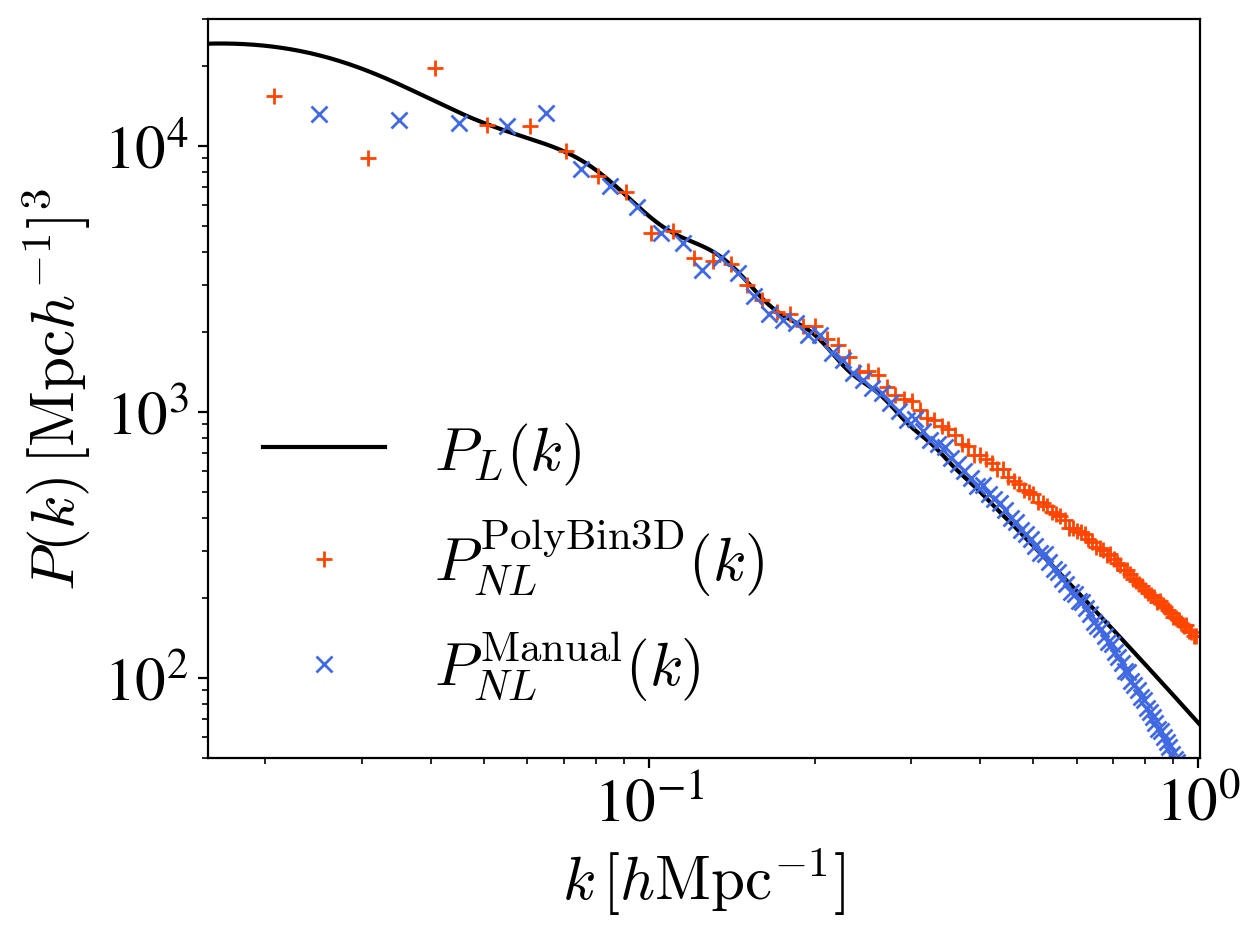

In [ ]:
ig,ax=plt.subplots()
ax.loglog(k_lin, pk_lin[0,:], color='k', ls ='-',label='$P_L(k)$')
ax.loglog(k_pb, pk_pb['p0'], color='orangered', ls='', marker ='+',label='$P^{\mathrm{PolyBin3D}}_{NL}(k)$')
ax.loglog(k_manual, pk_manual, color='royalblue', ls='', marker ='x',label='$P^{\mathrm{Manual}}_{NL}(k)$')
ax.set_xlabel('$k\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel('$P(k)\,[\mathrm{Mpc}h^{-1}]^3$')
ax.set_xlim(k_min,k_max);
ax.set_ylim(50,3e4);
ax.legend(frameon=False);

In [ ]:
def compute_CIC_kernel(L_side, N_side):
    """
    Compute the CIC kernel in Fourier space

    Parameters:
    -----------
    L_side : float
        L_side of the cubic grid
    N_side : int
        N_side of the cubic grid

    Returns:
    --------
    Wk_CIC : array, float
        The CIC kernel in Fourier space
    """
    k_nyq = (np.pi*N_side)/L_side
    k_freq = (2*np.pi)*np.fft.fftfreq(N_side, d=(L_side / N_side))

    W_CIC = np.sinc(k_freq/(2*k_nyq))**3 # Due to normalization, the np.sinc(x/pi) function actually corresponds to the mathematical sinc(x)

    return W_CIC**2

def compute_CICdeconcolved_pk(field1, boxsize, kbin_width, field2=None):
    """
    Compute auto- or cross-spectra

    Parameters
    ----------
    field1: (N_sidexN_sidexN_side) array, float
      Input density field 1
    field2: (N_sidexN_sidexN_side) array, float
      Input density field 2; same as field1 if field2=None
    boxsize: float
      L_side of the cubic box
    kbin_width: float
      The width of the Fourier wavenumber bin, delta k

    Returns
    -------
    k_bincenters: array, float
      The centers of the Fourier wavenumber bins
    pk/n_kmodes: array, float
      The bin-averaged auto- or cross-power spectrum
    """
    k_grid, n_kmodes, k_binedges = \
    construct_kgrid(field1,boxsize=boxsize,kbin_width=kbin_width)
    fft_norm = (boxsize**1.5)/(np.prod(field1.shape))
    field1_fft = np.fft.fftn(field1) * fft_norm
    if field2 is None:
        field2_fft = field1_fft
    else:
        field2_fft = np.fft.fftn(field2) * fft_norm
    weights = (field1_fft*field2_fft.conj()).real/(compute_CIC_kernel(L_side,N_side)**2)
    pk, k_binedges  = np.histogram(k_grid, weights=weights, bins=k_binedges, range=[k_binedges.min(), k_binedges.max()])
    k_bincenters = 0.5*(k_binedges[:-1]+k_binedges[1:])
    return k_bincenters, pk/n_kmodes

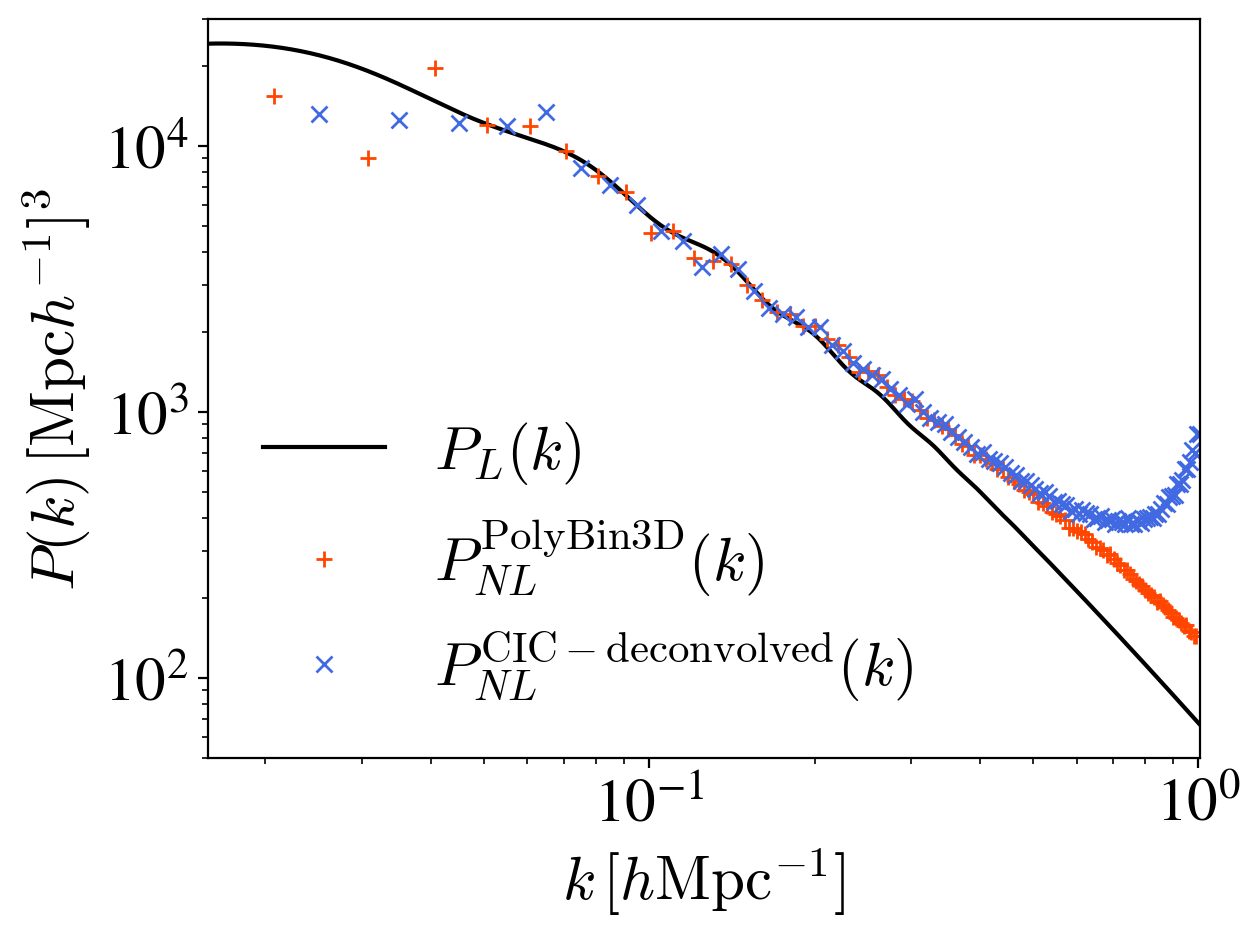

In [ ]:
k_CICdeconvolved, pk_CICdeconvolved = compute_CICdeconcolved_pk(final_field[batch_id],L_side,0.01)

ig,ax=plt.subplots()
ax.loglog(k_lin, pk_lin[0,:], color='k', ls ='-',label='$P_L(k)$')
ax.loglog(k_pb, pk_pb['p0'], color='orangered', ls='', marker ='+',label='$P^{\mathrm{PolyBin3D}}_{NL}(k)$')
ax.loglog(k_CICdeconvolved, pk_CICdeconvolved, color='royalblue', ls='', marker ='x',label='$P^{\mathrm{CIC-deconvolved}}_{NL}(k)$')
ax.set_xlabel('$k\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel('$P(k)\,[\mathrm{Mpc}h^{-1}]^3$')
ax.set_xlim(k_min,k_max);
ax.set_ylim(50,3e4);
ax.legend(frameon=False);